In [1]:
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from geopandas.tools import overlay
import matplotlib.pyplot as plt
import os 
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE

## Espacios Públicos Gdl

In [2]:
schema = 'espacios_publicos'
table = 'ep_amg'
gdf = aup.gdf_from_db(table,schema)
gdf.head()

,Fuente,Tipo,Uso,geometry
0,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672507.028 2272132.201, 672520.126 2..."
1,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672520.126 2272170.353, 672507.028 2..."
2,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672494.325 2272095.205, 672480.366 2..."
3,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672480.366 2272060.731, 672494.325 2..."
4,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672468.717 2272020.613, 672456.895 2..."


## Hexágonos Gdl

In [3]:
hex_schema = "hexgrid"
hex_table = "hexgrid_8_city"
c = 'Guadalajara'
query = f'SELECT * FROM {hex_schema}.{hex_table} WHERE \"metropolis\" LIKE \'{c}\''
hex_gdl = aup.gdf_from_query(query, geometry_col='geometry')
hex_gdl.head(5)

,geometry,hex_id_8,CVEGEO,metropolis
0,"POLYGON ((-103.60989 20.39686, -103.61044 20.4...",8849abc91bfffff,14002,Guadalajara
1,"POLYGON ((-103.61277 20.37822, -103.60824 20.3...",8849abc953fffff,14002,Guadalajara
2,"POLYGON ((-103.58960 20.38835, -103.58905 20.3...",8849abc901fffff,14002,Guadalajara
3,"POLYGON ((-103.66739 20.43582, -103.66683 20.4...",8849abc8adfffff,14002,Guadalajara
4,"POLYGON ((-103.66904 20.45140, -103.66452 20.4...",8849ab5249fffff,14002,Guadalajara


In [4]:
gdf = gdf.to_crs(hex_gdl.crs)
print("CRS of gdf:", gdf.crs)
print("CRS of hex_gdl:", hex_gdl.crs)

CRS of gdf: epsg:4326
CRS of hex_gdl: epsg:4326


## Dummy Variables
1 = Hexágonos que cuentan con espacios públicos

0 = Hexágonos que no cuentan con espacios públicos

In [5]:
def mapear_tipo(valor):
    tipos_1 = gpd.sjoin(hex_gdl, gdf, op='intersects')
    col = tipos_1['geometry']
    if valor in col:
        return 1
    else:
        return 0  # Puedes cambiar esto si deseas manejar otros valores

# Aplicar la función para crear la nueva columna
hex_gdl['EspPublico'] = hex_gdl['geometry'].apply(mapear_tipo)
hex_gdl.head()

,geometry,hex_id_8,CVEGEO,metropolis,EspPublico
0,"POLYGON ((-103.60989 20.39686, -103.61044 20.4...",8849abc91bfffff,14002,Guadalajara,0
1,"POLYGON ((-103.61277 20.37822, -103.60824 20.3...",8849abc953fffff,14002,Guadalajara,0
2,"POLYGON ((-103.58960 20.38835, -103.58905 20.3...",8849abc901fffff,14002,Guadalajara,0
3,"POLYGON ((-103.66739 20.43582, -103.66683 20.4...",8849abc8adfffff,14002,Guadalajara,0
4,"POLYGON ((-103.66904 20.45140, -103.66452 20.4...",8849ab5249fffff,14002,Guadalajara,0


In [6]:
hex_gdl.shape

(4095, 5)

In [7]:
contador_ceros = np.sum(hex_gdl['EspPublico'] == 0)
contador_uno = np.sum(hex_gdl['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno}')

Números de hexagonos sin Espacios Públicos: 3250 
Número de Hexágonos con Espacios Públicos: 845


Casi el 80% de los hexágonos no cuenta con Espacio Público, los métodos de clasificación van a estar muy sesgados por la discrepancia. Entonces tenemos que hacer que sean 50% ambos. Si hacemos un submuestreo y lo ponemos con el área que menos variables tiene, vamos a perder 60% de los datos y eso está aún peor. Entonces sobremuestrearé pero tampoco puedo sumarle 2,400 datos al área que le hace falta porque ahora estaría generando hexágonos sintéticos que no existen. Entonces lo que haré será quitarle 30% al que tiene 80% y ese 30% se lo agregaré al de 20%. De esta forma ambos tendrán 50%. Esto se hará después de juntar con el otro dataset.

## Hexágonos con info de humedad, vegetación y temperatura

select {tempe}.hex_id, {tempe}.geometry, {tempe}.city, {tempe}.res,

temp_diff_mean,

ndvi_mean, ndvi_std, ndvi_median, ndvi_max, ndvi_min, ndvi_diff, ndvi_tend,

ndmi_mean, ndmi_median, ndmi_diff

from raster_analysis.temperature_analysis_hex tempe

inner join raster_analysis.ndmi_analysis_hex ndmi

on tempe.hex_id = ndmi.hex_id 

inner join raster_analysis.ndvi_analysis_hex ndvi

on tempe.hex_id = ndvi.hex_id 

where tempe.city  = 'Guadalajara' and tempe.res = 11

In [8]:
hex_schema = "raster_analysis"
hex_table = "temperature_analysis_hex"
hex_tabl = "ndvi_analysis_hex"
hex_tablee = "ndmi_analysis_hex"
tempe = "tempe"
ndmi = "ndmi"
ndvi = "ndvi"
hex_id = "hex_id"
c = 'Guadalajara'
n = '11'
query = f'SELECT {tempe}.hex_id, {tempe}.geometry, {tempe}.city, {tempe}.res, temp_diff_mean,ndvi_mean, ndvi_std, ndvi_median, ndvi_max, ndvi_min, ndvi_diff, ndvi_tend,ndmi_mean, ndmi_median, ndmi_diff FROM {hex_schema}.{hex_table} {tempe} INNER JOIN {hex_schema}.{hex_tablee} {ndmi} ON {tempe}.{hex_id} = {ndmi}.{hex_id} INNER JOIN {hex_schema}.{hex_tabl} {ndvi} ON {tempe}.{hex_id} = {ndvi}.{hex_id} WHERE {tempe}.\"city\" = \'{c}\' AND {tempe}.\"res\" = {n}'
intt_gdl = aup.gdf_from_query(query, geometry_col='geometry')
intt_gdl.head(10)

,hex_id,geometry,city,res,temp_diff_mean,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff
0,8b49ab4b4385fff,"POLYGON ((-103.42244 20.71412, -103.42227 20.7...",Guadalajara,11,-2.591753,0.285744,0.064639,0.313281,0.337199,0.195493,0.141706,-0.001637,0.064559,0.059237,0.098502
1,8b49ab4b4352fff,"POLYGON ((-103.42642 20.71518, -103.42625 20.7...",Guadalajara,11,1.001997,0.251013,0.066054,0.247660,0.363757,0.169640,0.194117,0.000504,0.045462,0.042870,0.136833
2,8b49ab4b5c93fff,"POLYGON ((-103.42983 20.71742, -103.42966 20.7...",Guadalajara,11,-0.073338,0.433094,0.167217,0.395738,0.700481,0.225127,0.475354,-0.001176,0.082031,0.062196,0.297254
3,8b49ab4b4364fff,"POLYGON ((-103.42889 20.71318, -103.42872 20.7...",Guadalajara,11,-0.496962,0.483932,0.102783,0.516193,0.560024,0.355706,0.204318,-0.000635,0.170704,0.170154,0.102290
4,8b49ab4b4244fff,"POLYGON ((-103.42798 20.71776, -103.42781 20.7...",Guadalajara,11,-1.213368,0.516648,0.127617,0.526840,0.621555,0.346370,0.275185,-0.001570,0.176541,0.175209,0.160745
5,8b49ab4aa672fff,"POLYGON ((-103.49821 20.79712, -103.49803 20.7...",Guadalajara,11,-0.543837,0.070821,0.022515,0.072187,0.098399,0.045383,0.053017,-0.000515,-0.090500,-0.096391,0.086884
6,8b49ab591025fff,"POLYGON ((-103.42747 20.63604, -103.42729 20.6...",Guadalajara,11,2.871528,0.102646,0.027116,0.111599,0.128599,0.083657,0.044942,-0.000825,-0.045260,-0.062422,0.164418
7,8b49ab591113fff,"POLYGON ((-103.42534 20.63464, -103.42516 20.6...",Guadalajara,11,2.853993,0.063420,0.021638,0.070439,0.086512,0.031465,0.055048,-0.000508,-0.057703,-0.068111,0.141857
8,8b49ab591046fff,"POLYGON ((-103.42898 20.63911, -103.42880 20.6...",Guadalajara,11,2.303820,0.166774,0.049534,0.189609,0.201580,0.102965,0.098614,-0.001791,-0.039841,-0.054019,0.143024
9,8b49ab590a2dfff,"POLYGON ((-103.41703 20.62243, -103.41685 20.6...",Guadalajara,11,1.878299,0.071429,0.016019,0.073151,0.089076,0.053791,0.035285,-0.000443,-0.011300,-0.030330,0.131154


## Intersección

In [9]:
intt_gdl = intt_gdl.set_crs("EPSG:4326")
hex_gdl = hex_gdl.set_crs("EPSG:4326")

In [10]:
inter = gpd.sjoin(intt_gdl, hex_gdl, op='intersects')
inter.drop(columns=['index_right','city','res'], inplace=True)
inter.head()

,hex_id,geometry,temp_diff_mean,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff,hex_id_8,CVEGEO,metropolis,EspPublico
0,8b49ab4b4385fff,"POLYGON ((-103.42244 20.71412, -103.42227 20.7...",-2.591753,0.285744,0.064639,0.313281,0.337199,0.195493,0.141706,-0.001637,0.064559,0.059237,0.098502,8849ab4b43fffff,14120,Guadalajara,1
1,8b49ab4b4352fff,"POLYGON ((-103.42642 20.71518, -103.42625 20.7...",1.001997,0.251013,0.066054,0.247660,0.363757,0.169640,0.194117,0.000504,0.045462,0.042870,0.136833,8849ab4b43fffff,14120,Guadalajara,1
2,8b49ab4b5c93fff,"POLYGON ((-103.42983 20.71742, -103.42966 20.7...",-0.073338,0.433094,0.167217,0.395738,0.700481,0.225127,0.475354,-0.001176,0.082031,0.062196,0.297254,8849ab4b43fffff,14120,Guadalajara,1
3,8b49ab4b4364fff,"POLYGON ((-103.42889 20.71318, -103.42872 20.7...",-0.496962,0.483932,0.102783,0.516193,0.560024,0.355706,0.204318,-0.000635,0.170704,0.170154,0.102290,8849ab4b43fffff,14120,Guadalajara,1
4,8b49ab4b4244fff,"POLYGON ((-103.42798 20.71776, -103.42781 20.7...",-1.213368,0.516648,0.127617,0.526840,0.621555,0.346370,0.275185,-0.001570,0.176541,0.175209,0.160745,8849ab4b43fffff,14120,Guadalajara,1


In [11]:
inter.shape

(455422, 17)

In [12]:
pd.isna(inter).sum()

hex_id            0
geometry          0
temp_diff_mean    0
ndvi_mean         0
ndvi_std          0
ndvi_median       0
ndvi_max          0
ndvi_min          0
ndvi_diff         0
ndvi_tend         0
ndmi_mean         0
ndmi_median       0
ndmi_diff         0
hex_id_8          0
CVEGEO            0
metropolis        0
EspPublico        0
dtype: int64

In [15]:
cont_ceros = np.sum(inter['EspPublico'] == 0)
cont_uno = np.sum(inter['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {cont_ceros} \nNúmero de Hexágonos con Espacios Públicos: {cont_uno}')

Números de hexagonos sin Espacios Públicos: 141332 
Número de Hexágonos con Espacios Públicos: 314090


Ahora los hexágonos con espacios públicos tienen el 70% de los datos haremos un oversampling para tenerlos 50% ambos.

## Sobremuestreo

In [32]:
x = inter[['temp_diff_mean','ndvi_mean','ndvi_std','ndvi_median','ndvi_max','ndvi_min','ndvi_diff','ndvi_tend','ndmi_mean','ndmi_median','ndmi_diff']]
y = inter['EspPublico']

Se utilizará el método SMOTE para submuestrear porque este nos permite mantener la misma cantidad de datos que tenemos y así poder hacer un balanced ratio lo cual nos va a ayudar a reducir el riesgo de hacer un overfitting el cual genera que nuestros modelos de clasificación se sesguen y pierda valor el resultado porque no nos servirá para el mundo real de los datos, solo para este caso en específico.

In [28]:
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Resample the data to balance the classes
x_r, y_r = smote.fit_resample(x, y)

## Métodos de Clasificación

### Regresión Logística

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x_r,y_r, test_size = 0.2, random_state = 42)
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train)
x_test_scale = scaler.fit_transform(x_test)

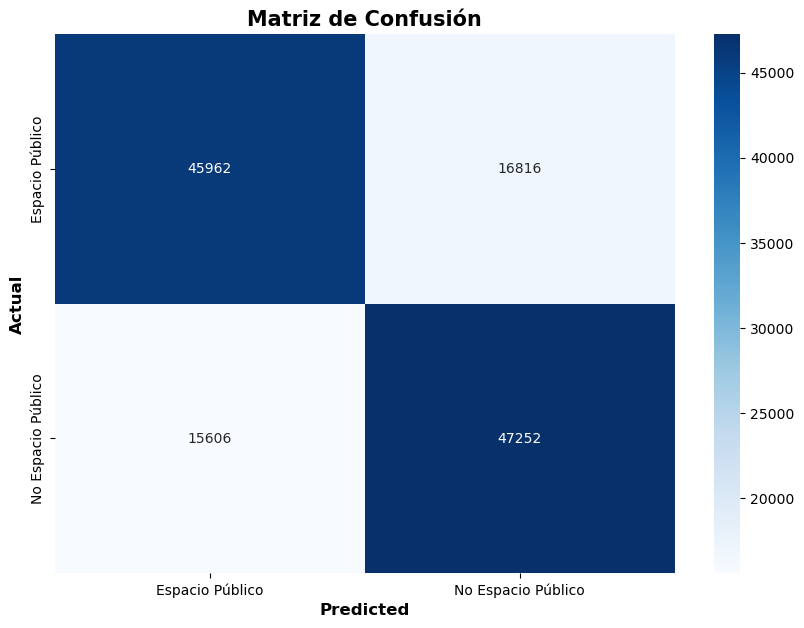

In [30]:
clf = LogisticRegression()
clf.fit(x_train_scale, y_train)
y_pred = clf.predict(x_test_scale)
cm = confusion_matrix(y_test,y_pred)
class_labels = ['Espacio Público', 'No Espacio Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [31]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7419370244197523


### Naive Bayes

In [23]:
nb = GaussianNB()
nb.fit(x_train, y_train)

GaussianNB()

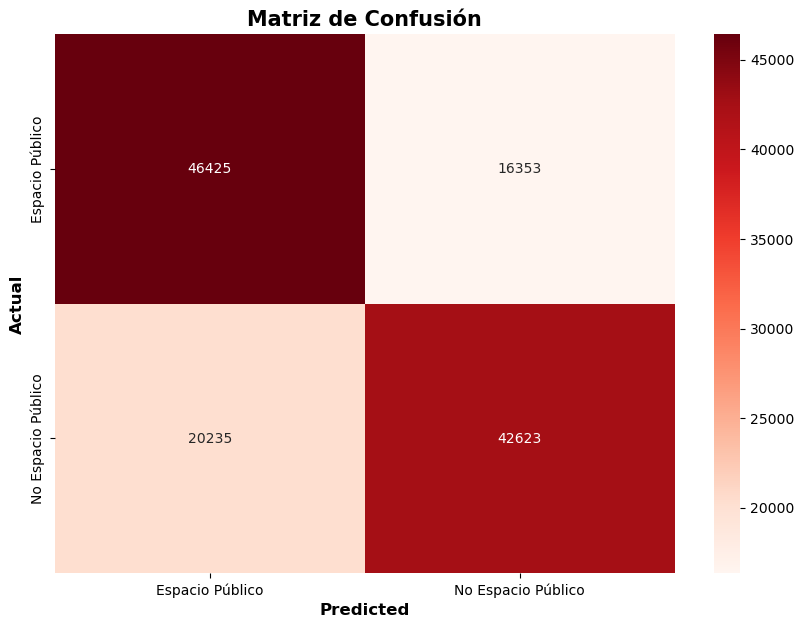

In [24]:
y_prend = nb.predict(x_test)
cm = confusion_matrix(y_test, y_prend)
class_labels = ['Espacio Público', 'No Espacio Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [25]:
accuracy = accuracy_score(y_test, y_prend)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7087777388646567


Podemos observar que tenemos en ambos arriba de 70% de accuracy. El de regresión logística tiene un 75% de accuracy que es algo ya muy aceptable para problemas del mundo real.

## Matriz de correlación

Haremos una matriz de correlación para verificar las variables que estamos utilizando para clasificar, para ver si encontramos algo que pueda mejorar el accuracy de la clasificación. Lo primero que haremos es ver si hay variables dependientes con la que buscamos clasificar para así poder quitarlas en los modelos de clasificación.

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


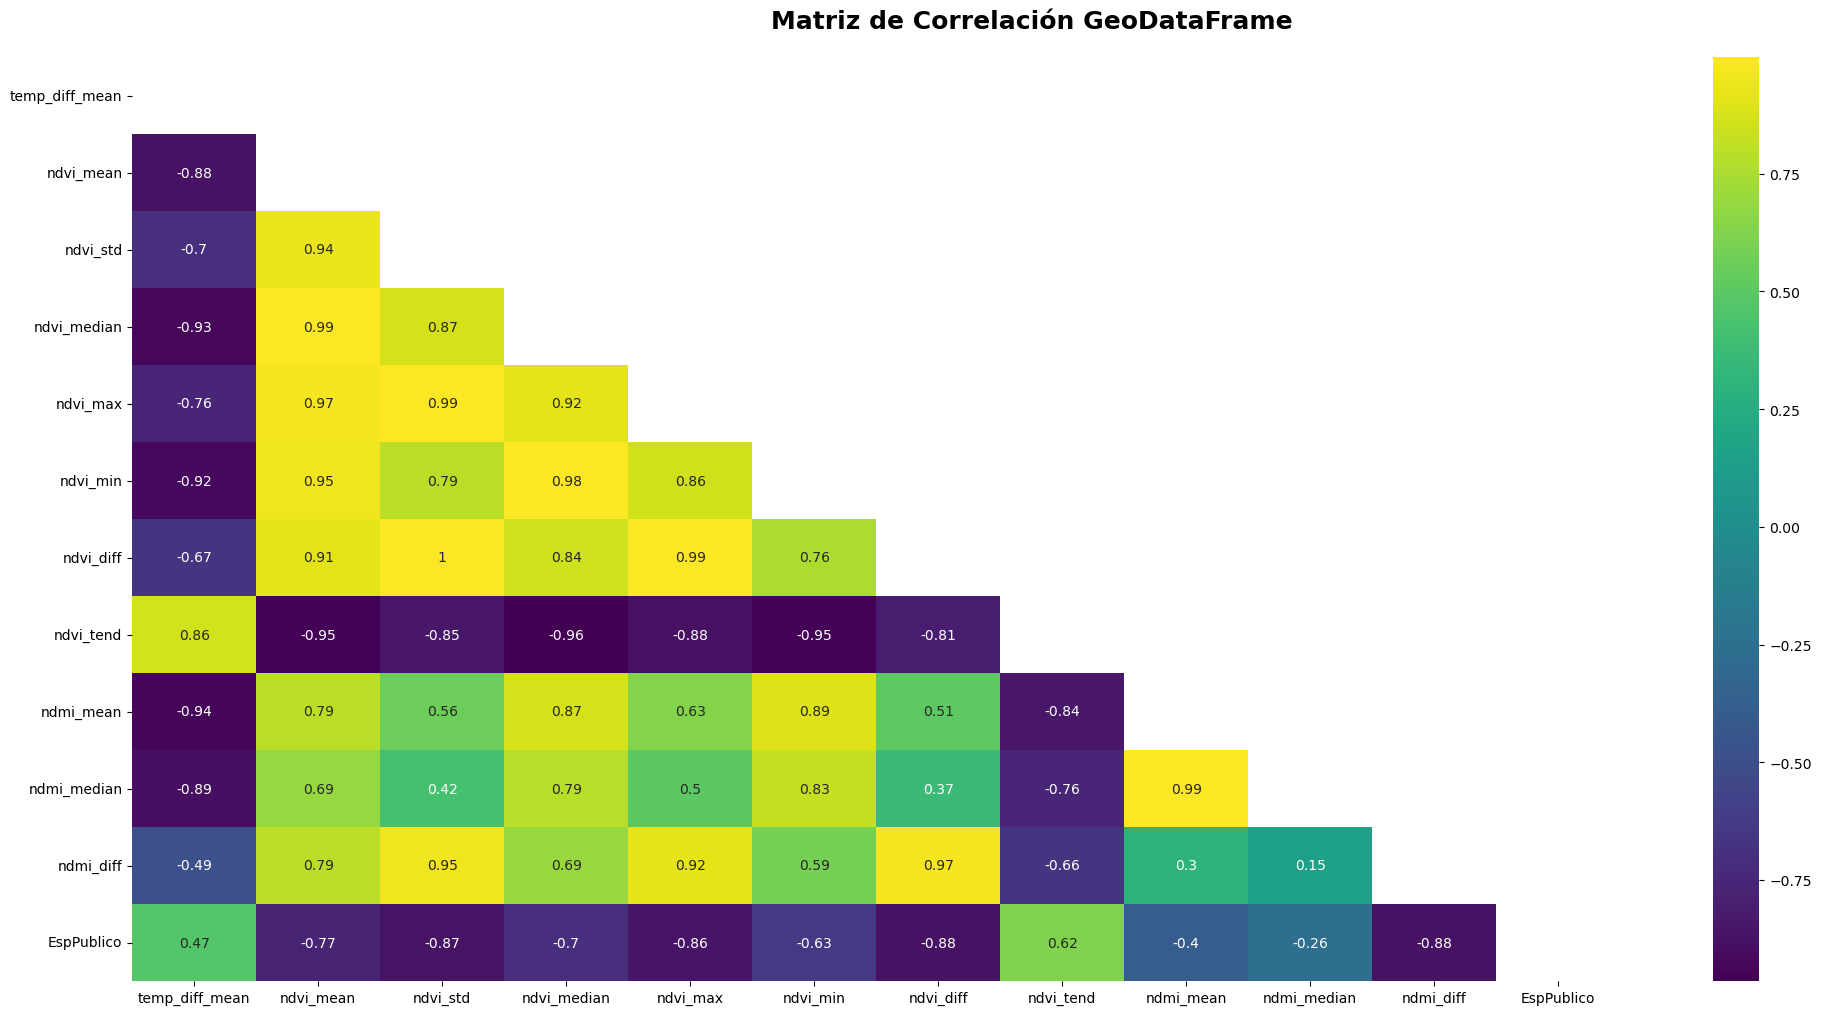

In [26]:
correlacion = inter.corr()

figsize=(24, 12)
        
fig = plt.figure(figsize = figsize)

# Título
plt.suptitle(
    "Matriz de Correlación GeoDataFrame",
    color='black',
    fontsize=18,
    #loc='center',
    fontweight='bold',
    style='normal',
    family='Arial',
    x = 0.5,
    y=0.92)

# Subtítulo de gráfico

nota = '''Nota: Hay multicolinealidad en algunas variables'''

n = ''
#fig.text(0.5, 0.87, nota, ha='center', fontsize=12, style ='italic', family='Arial')

# creating mask
mask = np.triu(np.ones_like(correlacion))

sns.heatmap(correlacion.corr(), annot = True, mask=mask,
            cmap = 'viridis');

#plt.savefig('matriz_correlacion_Husky_10_Ed_C.png')

plt.show()

Observamos que todas las variables son independientes con respecto a la variable 'EspPublico' que es la que se busca clasificar. Por lo tanto, no podemos quitar ninguna variable en los modelos de clasificación. Ahora intentaremos el PCA.

## PCA

Se implementa el PCA para reducir dimensionalidad, es decir, usar solo las columnas que nos pueden decir el 70% de clasificación 